In [104]:
!pip install lifetimes
!pip install sqlalchemy

In [105]:
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data

In [106]:
from sklearn.metrics import silhouette_score

In [107]:
order_items = pd.read_parquet('/content/drive/MyDrive/order_items_optimized.parquet')

In [108]:
# 구매건만 남기기
order_items_extracted = order_items.query('status != "Returned" and status != "Cancelled"')


In [109]:
# 'created_at' 열을 datetime 형식으로 변환
order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'])

# UTC에서 로컬 시간으로 변환
order_items_extracted['created_at'] = order_items_extracted['created_at'].dt.tz_localize(None)

# 'created_at' 열의 데이터 타입 확인
print(order_items_extracted['created_at'].dtype)

# "2023-12-01" 이전의 행만 선택
order_items_extracted = order_items_extracted.query('created_at < "2023-12-01"')

datetime64[ns]


In [110]:
# Recency 계산 (데이터 제일 최근 날짜 + 1일 기준)
recency = order_items_extracted .groupby('user_id')['created_at'].max().reset_index()
recency['recency'] = (order_items_extracted['created_at'].max()+ pd.to_timedelta(1, unit='d') - recency['created_at']).dt.days

In [111]:
# Frequency 계산
frequency = order_items_extracted.groupby('user_id')['order_id'].nunique().reset_index()

In [112]:
# Monetary 계산
monetary = order_items_extracted.groupby('user_id')['sale_price'].sum().reset_index()

In [113]:
# RFM 데이터프레임 생성
rfm = pd.merge(recency[['user_id', 'recency']], frequency, on='user_id')
rfm = pd.merge(rfm, monetary, on='user_id')
rfm= rfm.rename(columns={'sale_price' : 'monetary'})
rfm["monetary"] = rfm["monetary"] / rfm["order_id"]
rfm


,user_id,recency,order_id,monetary
0,1,499,1,159.990000
1,2,649,1,22.000000
2,3,115,4,100.550000
3,4,409,1,148.000000
4,6,599,1,144.820004
...,...,...,...,...
58459,99989,91,1,15.120000
58460,99992,479,1,55.950001
58461,99996,261,2,61.935000
58462,99998,132,3,38.996667


In [144]:
#monetary 총매출이 아닌 평균으로 바꾸기
rfm["monetary"] = rfm["monetary"] / rfm["order_id"]

In [145]:
rfm

,user_id,recency,order_id,monetary
0,1,499,1,159.990000
1,2,649,1,22.000000
2,3,115,4,1.571094
3,4,409,1,148.000000
4,6,599,1,144.820004
...,...,...,...,...
58459,99989,91,1,15.120000
58460,99992,479,1,55.950001
58461,99996,261,2,7.741875
58462,99998,132,3,1.444321


In [146]:
from sklearn.cluster import KMeans

In [148]:
# 모델 초기화
kmeans = KMeans(n_clusters=3, random_state=42)

# RFM 데이터를 사용하여 모델 학습
rfm_data = rfm[['user_id','recency', 'order_id', 'monetary']]
kmeans.fit(rfm_data[['recency', 'order_id', 'monetary']])

# 클러스터링 결과 확인
rfm_data['cluster'] = kmeans.labels_

# 결과 출력
print(rfm_data)

       user_id  recency  order_id    monetary  cluster
0            1      499         1  159.990000        2
1            2      649         1   22.000000        2
2            3      115         4    1.571094        0
3            4      409         1  148.000000        2
4            6      599         1  144.820004        2
...        ...      ...       ...         ...      ...
58459    99989       91         1   15.120000        0
58460    99992      479         1   55.950001        2
58461    99996      261         2    7.741875        0
58462    99998      132         3    1.444321        0
58463   100000     1190         1  129.949997        1

[58464 rows x 5 columns]


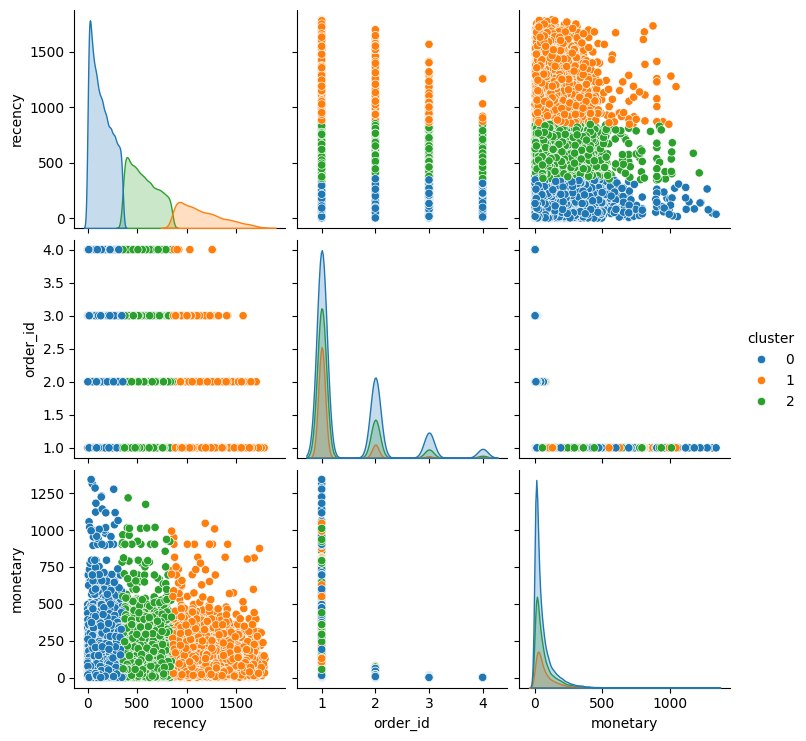

In [149]:
features = ['recency', 'order_id', 'monetary']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

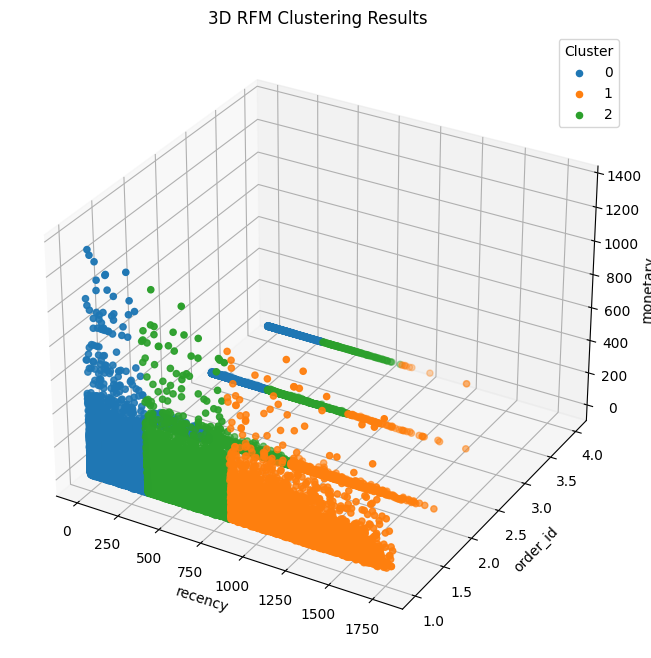

In [150]:
x_feature = 'recency'
y_feature = 'order_id'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [119]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette_avg = silhouette_score(rfm_data, rfm_data['cluster'])

# 실루엣 점수 출력
#print(f'Silhouette Score: {silhouette_avg}')

In [151]:
print(rfm_data.columns)

Index(['user_id', 'recency', 'order_id', 'monetary', 'cluster'], dtype='object')


In [152]:
import numpy as np

# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data['G'] = rfm_data['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data['K'] = rfm_data['monetary'] * rfm_data['order_id']  # 현재 고객 가치
rfm_data['S'] = rfm_data['monetary'] * rfm_data['order_id'] / rfm_data['recency']  # 잔존 고객 가치
rfm_data['M'] = np.log(rfm_data['order_id']) * rfm_data['monetary']  # 모멘텀 고객 가치
#rfm_data['S'] = rfm_data['monetary'] * rfm_data['order_id'] / rfm_data['recency']  # 소셜 고객 가치
rfm_data['Q'] = rfm_data['monetary'] / rfm_data['order_id']  # 품질 고객 가치
rfm_data['J'] = rfm_data['monetary'] * np.log(rfm_data['recency'] )  # 행동 고객 가치


In [153]:
rfm_data['CLV'] = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']].sum(axis=1)
rfm_data

,user_id,recency,order_id,monetary,cluster,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,2,159.990000,159.990000,0.320621,0.000000,159.990000,993.954848,1474.245468
1,2,649,1,22.000000,2,22.000000,22.000000,0.033898,0.000000,22.000000,142.459520,208.493418
2,3,115,4,1.571094,0,1.571094,6.284375,0.054647,2.177998,0.392773,7.454733,17.935621
3,4,409,1,148.000000,2,148.000000,148.000000,0.361858,0.000000,148.000000,890.029843,1334.391701
4,6,599,1,144.820004,2,144.820004,144.820004,0.241770,0.000000,144.820004,926.161807,1360.863587
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,0,15.120000,15.120000,0.166154,0.000000,15.120000,68.204196,113.730351
58460,99992,479,1,55.950001,2,55.950001,55.950001,0.116806,0.000000,55.950001,345.306653,513.273461
58461,99996,261,2,7.741875,0,7.741875,15.483750,0.059325,5.366259,3.870938,43.079822,75.601968
58462,99998,132,3,1.444321,0,1.444321,4.332963,0.032825,1.586749,0.481440,7.052333,14.930632


In [155]:
# Selecting relevant columns for clustering
X = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data['cluster'] = kmeans.labels_

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['G', 'K', 'S', 'M', 'Q', 'J'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data['cluster'].value_counts())

            G           K         S             M           Q            J
0   85.025310   85.279124  1.076909  1.759308e-01   84.898402   466.034126
1   20.374062   24.652270  0.927234  2.853550e+00   18.362481   101.692552
2  184.413537  184.413537  1.166907  4.285461e-14  184.413537  1066.265463
3  348.657615  348.657615  1.475624 -2.886580e-15  348.657615  2101.206392
4  813.162420  813.162420  3.522069  1.332268e-15  813.162420  4847.456272
cluster
1    36660
0    14132
2     5978
3     1537
4      157
Name: count, dtype: int64


In [156]:
rfm_data

,user_id,recency,order_id,monetary,cluster,G,K,S,M,Q,J,CLV
0,1,499,1,159.990000,2,159.990000,159.990000,0.320621,0.000000,159.990000,993.954848,1474.245468
1,2,649,1,22.000000,1,22.000000,22.000000,0.033898,0.000000,22.000000,142.459520,208.493418
2,3,115,4,1.571094,1,1.571094,6.284375,0.054647,2.177998,0.392773,7.454733,17.935621
3,4,409,1,148.000000,2,148.000000,148.000000,0.361858,0.000000,148.000000,890.029843,1334.391701
4,6,599,1,144.820004,2,144.820004,144.820004,0.241770,0.000000,144.820004,926.161807,1360.863587
...,...,...,...,...,...,...,...,...,...,...,...,...
58459,99989,91,1,15.120000,1,15.120000,15.120000,0.166154,0.000000,15.120000,68.204196,113.730351
58460,99992,479,1,55.950001,0,55.950001,55.950001,0.116806,0.000000,55.950001,345.306653,513.273461
58461,99996,261,2,7.741875,1,7.741875,15.483750,0.059325,5.366259,3.870938,43.079822,75.601968
58462,99998,132,3,1.444321,1,1.444321,4.332963,0.032825,1.586749,0.481440,7.052333,14.930632


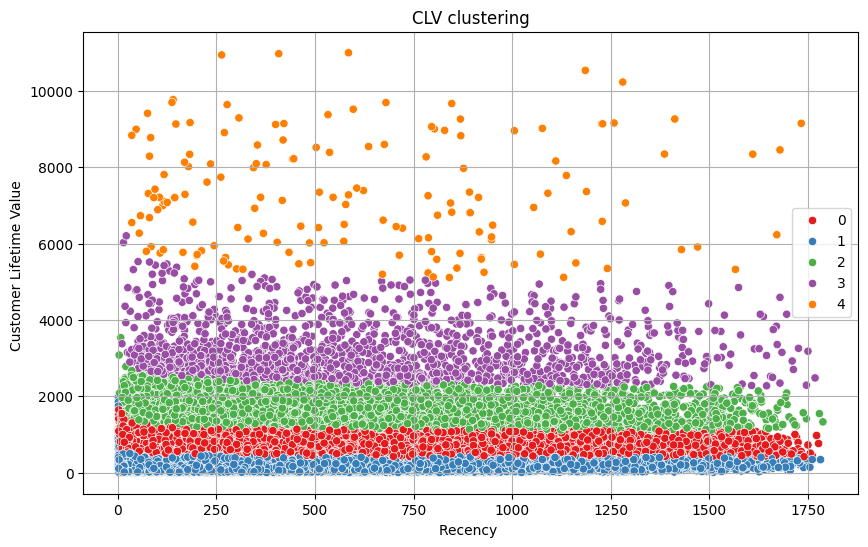

In [157]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency', y='CLV', hue='cluster', data=rfm_data, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency ')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering')
plt.legend()
plt.grid(True)
plt.show()

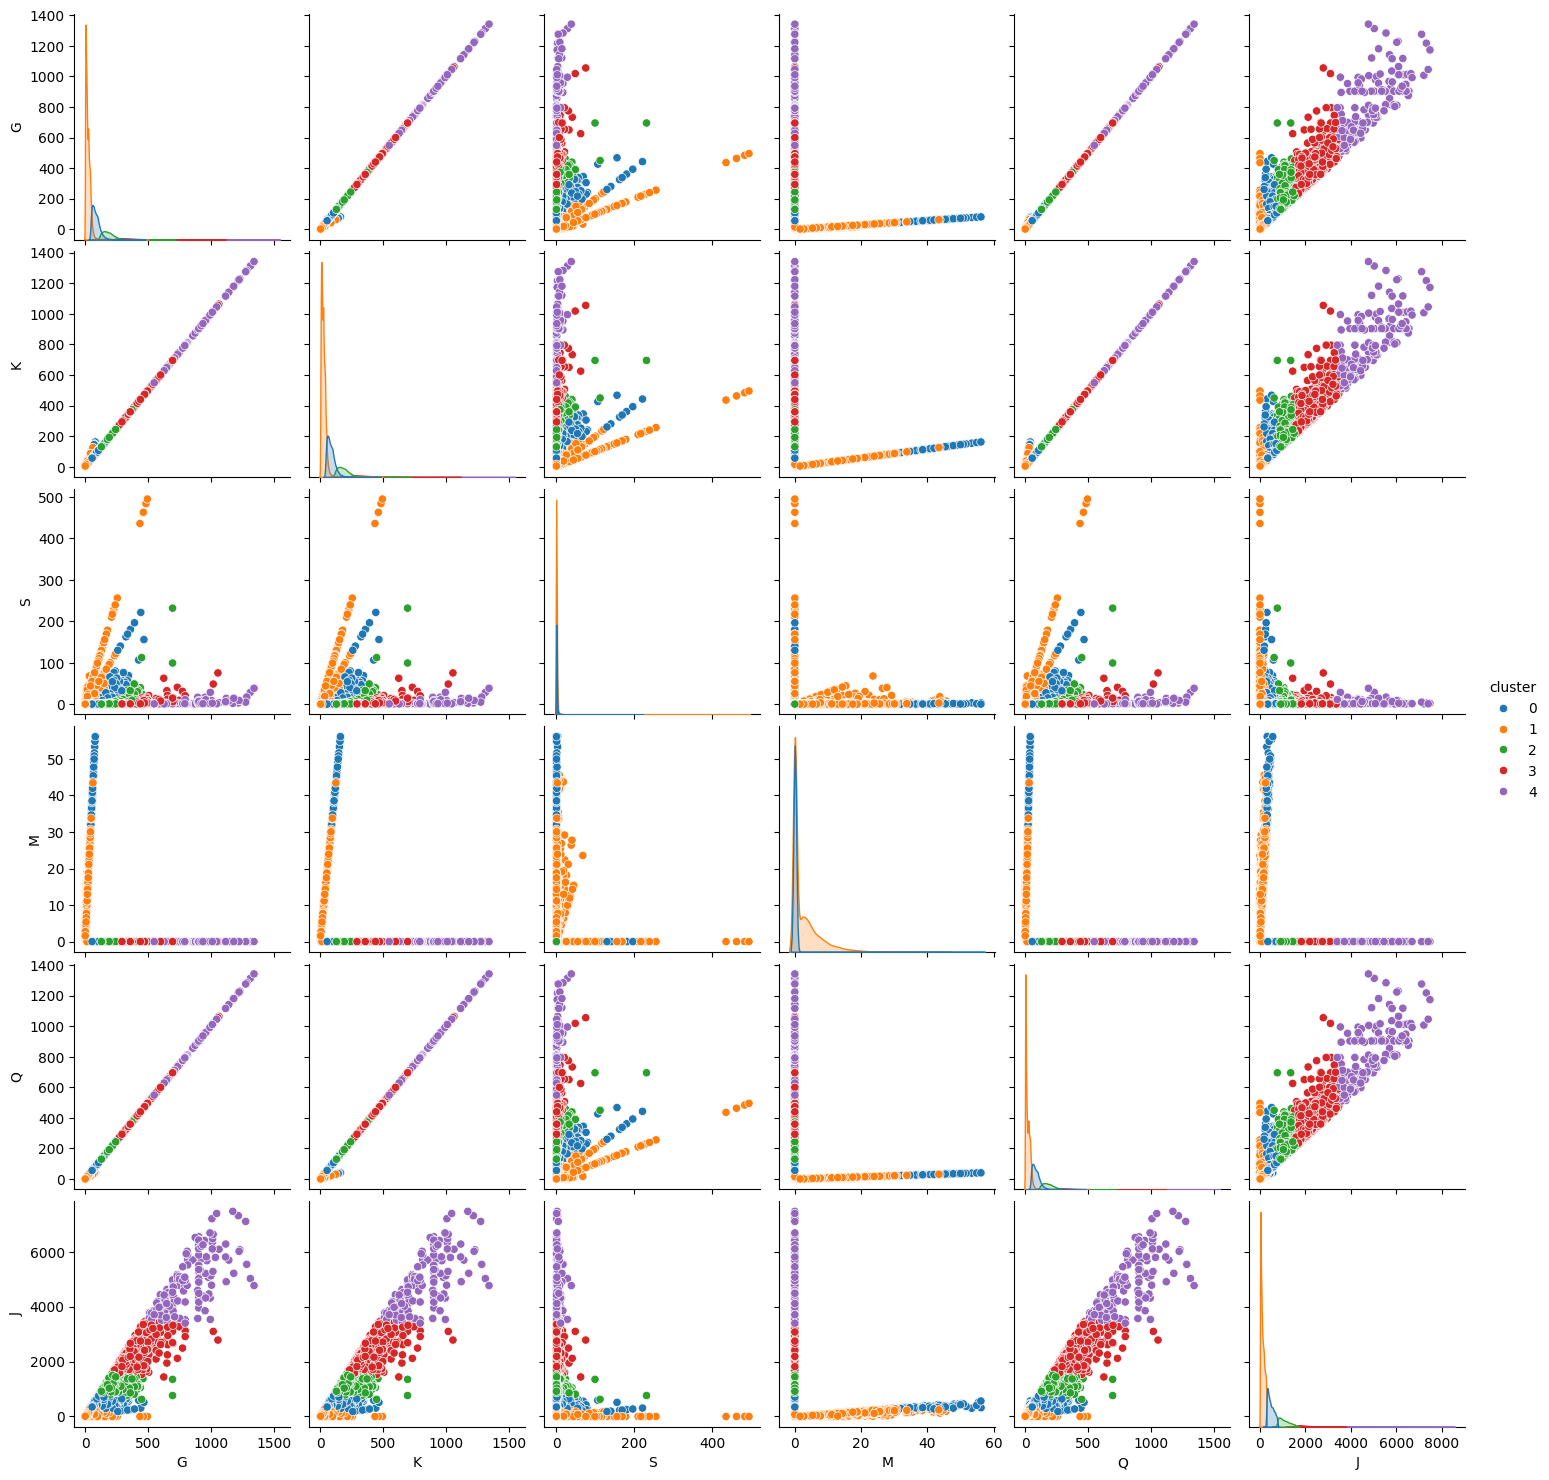

In [158]:
features = ['G', 'K', 'S', 'M', 'Q', 'J']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

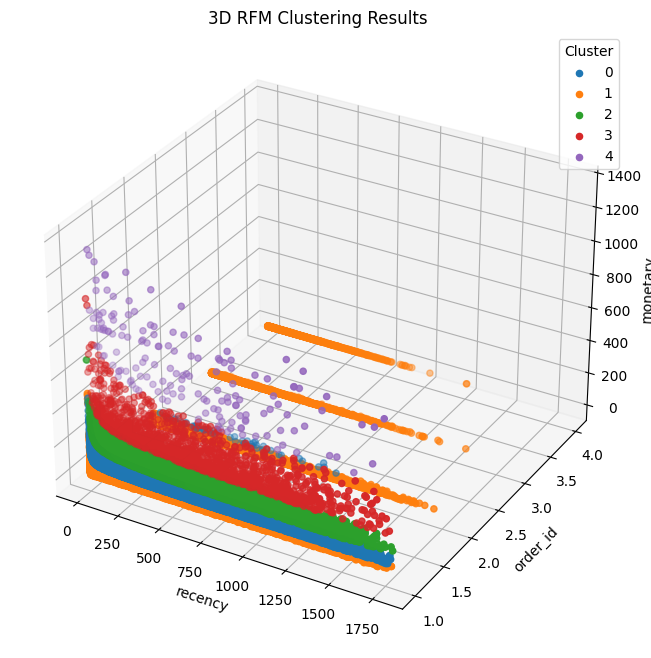

In [159]:
x_feature = 'recency'
y_feature = 'order_id'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')